In [ ]:
!pip install scikit-optimize imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression 3
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
# Load and preprocess data
lung_data = pd.read_csv("/content/sample_data/survey lung cancer.csv")
lung_data.columns = lung_data.columns.str.strip()
lung_data['GENDER'] = lung_data['GENDER'].map({"M": 1, "F": 2})
lung_data['LUNG_CANCER'] = lung_data['LUNG_CANCER'].map({"YES": 1, "NO": 2})
lung_data = lung_data.dropna()

In [ ]:
# Initial data exploration
print("Dataset Shape:", lung_data.shape)
print("\nMissing Values:\n", lung_data.isnull().sum())
print("\nData Types:\n", lung_data.dtypes)
print("\nDataset Description:\n", lung_data.describe())
lung_data.info()
print("\nClass Distribution:\n", lung_data['LUNG_CANCER'].value_counts())

Dataset Shape: (309, 16)

Missing Values:
 GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

Data Types:
 GENDER                   int64
AGE                      int64
SMOKING                  int64
YELLOW_FINGERS           int64
ANXIETY                  int64
PEER_PRESSURE            int64
CHRONIC DISEASE          int64
FATIGUE                  int64
ALLERGY                  int64
WHEEZING                 int64
ALCOHOL CONSUMING        int64
COUGHING                 int64
SHORTNESS OF BREATH      int64
SWALLOWING DIFFICULTY    int64
CHEST PAIN               int64
LUNG_CANCER              int64
dt

In [ ]:
# Enhanced feature engineering
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_poly = poly.fit_transform(lung_data.drop('LUNG_CANCER', axis=1))
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_poly)
x_all = pd.DataFrame(x_scaled, columns=poly.get_feature_names_out(lung_data.columns[:-1]))

# Feature selection
selector = SelectKBest(score_func=f_classif, k=25)  # Select top 25 features
x_selected = selector.fit_transform(x_all, lung_data['LUNG_CANCER'])
selected_features = x_all.columns[selector.get_support()].tolist()
x = x_all[selected_features]
y = lung_data['LUNG_CANCER']

In [ ]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3, random_state=0, stratify=y)
print("\nTraining set length:", len(x_train))
print("Test set length:", len(x_test))


Training set length: 206
Test set length: 103


In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
x_train_bal, y_train_bal = smote.fit_resample(x_train, y_train)

In [ ]:
# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Dictionaries to store accuracies
accuracies = {}


=== Logistic Regression ===


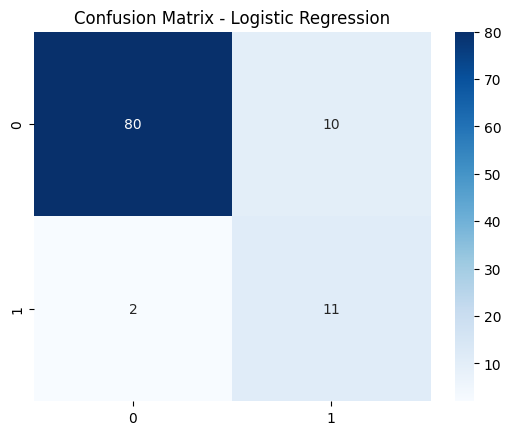

Accuracy: 0.8835
Best Params: OrderedDict([('C', 23.501951659022716), ('max_iter', 4899), ('penalty', 'l1'), ('solver', 'liblinear')])
Precision: 0.975609756097561
Recall: 0.8888888888888888
F1 score: 0.9302325581395349


In [ ]:
# 1. Logistic Regression
print("\n=== Logistic Regression ===")
param_space_lr = {
    'C': Real(0.01, 100.0, prior='log-uniform'),
    'solver': Categorical(['liblinear', 'saga']),
    'penalty': Categorical(['l1', 'l2']),
    'max_iter': Integer(1000, 5000)
}
model1_opt = BayesSearchCV(LogisticRegression(), param_space_lr, n_iter=50, cv=skf, random_state=42, n_jobs=-1)
model1_opt.fit(x_train_bal, y_train_bal)
model1_best = model1_opt.best_estimator_
prediction1 = model1_best.predict(x_test)
accuracies['Logistic Regression'] = accuracy_score(y_test, prediction1)

cm1 = confusion_matrix(y_test, prediction1)
sns.heatmap(cm1, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print(f"Accuracy: {accuracies['Logistic Regression']:.4f}")
print(f"Best Params: {model1_opt.best_params_}")
print("Precision:", precision_score(y_test, prediction1))
print("Recall:", recall_score(y_test, prediction1))
print("F1 score:", f1_score(y_test, prediction1))


=== KNN ===


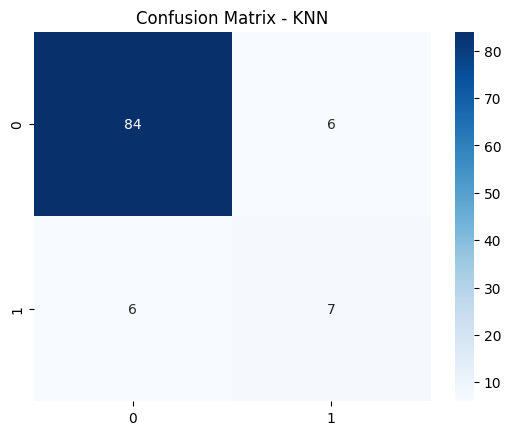

Accuracy: 0.8835
Best Params: OrderedDict([('metric', 'euclidean'), ('n_neighbors', 1), ('p', 1), ('weights', 'uniform')])
Precision: 0.9333333333333333
Recall: 0.9333333333333333
F1 score: 0.9333333333333333


In [ ]:
# 2. KNN
print("\n=== KNN ===")
from skopt.space import Integer, Categorical, Real # Importing necessary objects from skopt.space
param_space_knn = {
    'n_neighbors': Integer(1, 15),
    'weights': Categorical(['uniform', 'distance']),
    'metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
    'p': Integer(1, 3)
}
model2_opt = BayesSearchCV(KNeighborsClassifier(), param_space_knn, n_iter=50, cv=skf, random_state=42, n_jobs=-1)
model2_opt.fit(x_train_bal, y_train_bal)
model2_best = model2_opt.best_estimator_
prediction2 = model2_best.predict(x_test)
accuracies['KNN'] = accuracy_score(y_test, prediction2)

cm2 = confusion_matrix(y_test, prediction2)
sns.heatmap(cm2, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - KNN")
plt.show()

print(f"Accuracy: {accuracies['KNN']:.4f}")
print(f"Best Params: {model2_opt.best_params_}")
print("Precision:", precision_score(y_test, prediction2))
print("Recall:", recall_score(y_test, prediction2))
print("F1 score:", f1_score(y_test, prediction2))


=== Decision Tree ===


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(20), np.int64(1), np.int64(2), np.str_('random')] before, using random point ['gini', np.int64(19), np.int64(6), np.int64(16), 'random']
  warnings.warn(


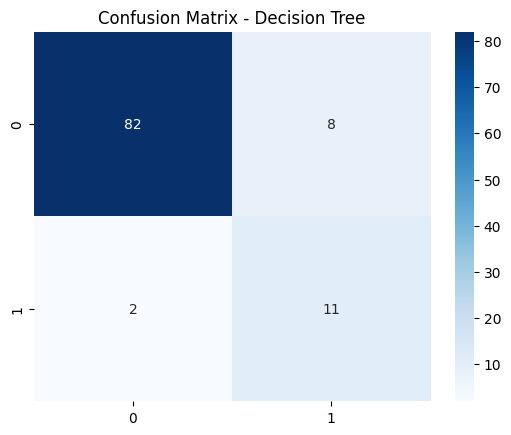

Accuracy: 0.9029
Best Params: OrderedDict([('estimator__criterion', 'entropy'), ('estimator__max_depth', 19), ('estimator__min_samples_leaf', 2), ('estimator__min_samples_split', 5), ('estimator__splitter', 'random')])
Precision: 0.9761904761904762
Recall: 0.9111111111111111
F1 score: 0.9425287356321839


In [ ]:
# 3. Decision Tree
print("\n=== Decision Tree ===")
param_space_dt = {
    'estimator__max_depth': Integer(5, 20),
    'estimator__min_samples_split': Integer(2, 20),
    'estimator__min_samples_leaf': Integer(1, 10),
    'estimator__criterion': Categorical(['gini', 'entropy']),
    'estimator__splitter': Categorical(['best', 'random'])
}  # Update parameter names with 'estimator__' prefix

dt_base = DecisionTreeClassifier(random_state=42)
# Use 'estimator' instead of 'base_estimator' for older scikit-learn versions
bagging_dt = BaggingClassifier(estimator=dt_base, n_estimators=20, random_state=42)
model3_opt = BayesSearchCV(bagging_dt, param_space_dt, n_iter=50, cv=skf, random_state=42, n_jobs=-1)
model3_opt.fit(x_train_bal, y_train_bal)
model3_best = model3_opt.best_estimator_
prediction3 = model3_best.predict(x_test)
accuracies['Decision Tree'] = accuracy_score(y_test, prediction3)

cm3 = confusion_matrix(y_test, prediction3)
sns.heatmap(cm3, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

print(f"Accuracy: {accuracies['Decision Tree']:.4f}")
print(f"Best Params: {model3_opt.best_params_}")
print("Precision:", precision_score(y_test, prediction3))
print("Recall:", recall_score(y_test, prediction3))
print("F1 score:", f1_score(y_test, prediction3))


=== SVM ===


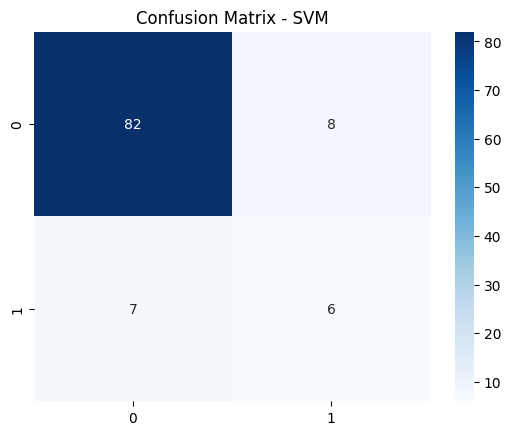

Accuracy: 0.8544
Best Params: OrderedDict([('estimator__C', 8.630354621690648), ('estimator__degree', 3), ('estimator__gamma', 0.36070714978894874), ('estimator__kernel', 'rbf')])
Precision: 0.9213483146067416
Recall: 0.9111111111111111
F1 score: 0.9162011173184358


In [ ]:
# 4. SVM
print("\n=== SVM ===")
param_space_svm = {
    'estimator__C': Real(0.1, 100.0, prior='log-uniform'), # Update parameter name
    'estimator__kernel': Categorical(['linear', 'rbf', 'poly']), # Update parameter name
    'estimator__gamma': Real(0.001, 1.0, prior='log-uniform'), # Update parameter name
    'estimator__degree': Integer(2, 5) # Update parameter name
}
svm_base = SVC(probability=True, random_state=42)
bagging_svm = BaggingClassifier(estimator=svm_base, n_estimators=20, random_state=42)
model4_opt = BayesSearchCV(bagging_svm, param_space_svm, n_iter=50, cv=skf, random_state=42, n_jobs=-1)
model4_opt.fit(x_train_bal, y_train_bal)
model4_best = model4_opt.best_estimator_
prediction4 = model4_best.predict(x_test)
accuracies['SVM'] = accuracy_score(y_test, prediction4)

cm4 = confusion_matrix(y_test, prediction4)
sns.heatmap(cm4, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - SVM")
plt.show()

print(f"Accuracy: {accuracies['SVM']:.4f}")
print(f"Best Params: {model4_opt.best_params_}")
print("Precision:", precision_score(y_test, prediction4))
print("Recall:", recall_score(y_test, prediction4))
print("F1 score:", f1_score(y_test, prediction4))


=== Naive Bayes ===


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [9.885508382663358e-10, np.int64(48)] before, using random point [1.6649201379513106e-10, np.int64(15)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0241609966478823e-11, np.int64(50)] before, using random point [1.3331372911984984e-08, np.int64(39)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.6577881449290313e-09, np.int64(41)] before, using random point [3.5250843969010573e-09, np.int64(30)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.1543635995404844e-08, np.int64(17)] before, using random point [7.147071252549188e-10, np.int64(11)]
  warnings.warn

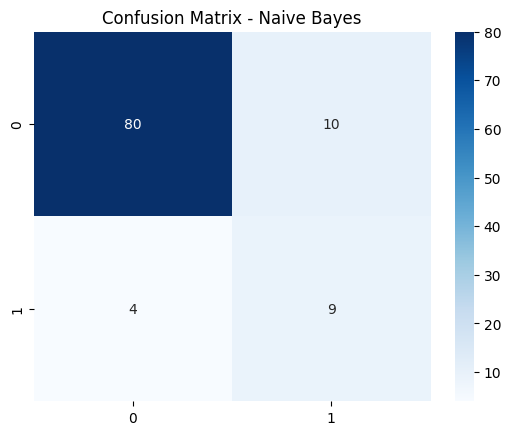

Accuracy: 0.8641
Best Params: OrderedDict([('estimator__var_smoothing', 4.3693399475103194e-10), ('n_estimators', 39)])
Precision: 0.9523809523809523
Recall: 0.8888888888888888
F1 score: 0.9195402298850575


In [ ]:
# 5. Naive Bayes
print("\n=== Naive Bayes ===")
param_space_nb = {
    'estimator__var_smoothing': Real(1e-11, 1e-7, prior='log-uniform'),
    'n_estimators': Integer(10, 50)
}
nb_base = GaussianNB()
bagging_nb = BaggingClassifier(estimator=nb_base, random_state=42)
model5_opt = BayesSearchCV(bagging_nb, param_space_nb, n_iter=50, cv=skf, random_state=42, n_jobs=-1)
model5_opt.fit(x_train_bal, y_train_bal)
model5_best = model5_opt.best_estimator_
prediction5 = model5_best.predict(x_test)
accuracies['Naive Bayes'] = accuracy_score(y_test, prediction5)

cm5 = confusion_matrix(y_test, prediction5)
sns.heatmap(cm5, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

print(f"Accuracy: {accuracies['Naive Bayes']:.4f}")
print(f"Best Params: {model5_opt.best_params_}")
print("Precision:", precision_score(y_test, prediction5))
print("Recall:", recall_score(y_test, prediction5))
print("F1 score:", f1_score(y_test, prediction5))


=== Random Forest ===


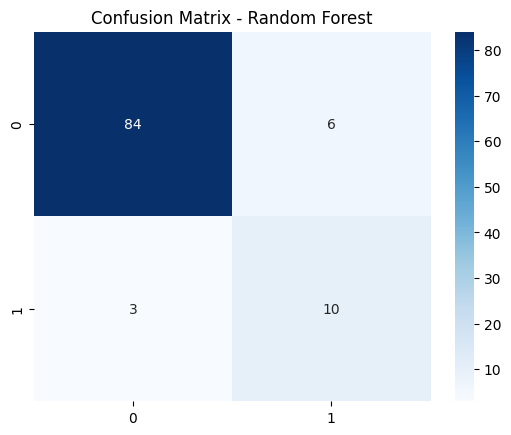

Accuracy: 0.9126
Best Params: OrderedDict([('bootstrap', True), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 8), ('n_estimators', 115)])
Precision: 0.9655172413793104
Recall: 0.9333333333333333
F1 score: 0.9491525423728814


In [ ]:
# 6. Random Forest
print("\n=== Random Forest ===")
param_space_rf = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(10, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'bootstrap': Categorical([True, False])
}
model6_opt = BayesSearchCV(RandomForestClassifier(random_state=42), param_space_rf, n_iter=50, cv=skf, random_state=42, n_jobs=-1)
model6_opt.fit(x_train_bal, y_train_bal)
model6_best = model6_opt.best_estimator_
prediction6 = model6_best.predict(x_test)
accuracies['Random Forest'] = accuracy_score(y_test, prediction6)

cm6 = confusion_matrix(y_test, prediction6)
sns.heatmap(cm6, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print(f"Accuracy: {accuracies['Random Forest']:.4f}")
print(f"Best Params: {model6_opt.best_params_}")
print("Precision:", precision_score(y_test, prediction6))
print("Recall:", recall_score(y_test, prediction6))
print("F1 score:", f1_score(y_test, prediction6))


=== Maya Hybrid ===


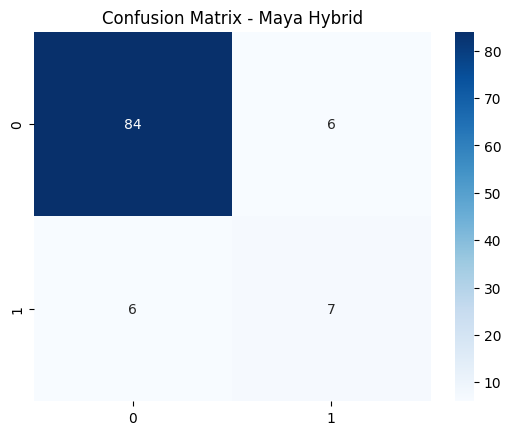

Accuracy: 0.8835
Precision: 0.9333333333333333
Recall: 0.9333333333333333
F1 score: 0.9333333333333333


In [ ]:
# Maya Hybrid
print("\n=== Maya Hybrid ===")
base_estimators = [
    ('lr', model1_best),
    ('knn', model2_best),
    ('dt', model3_best),
    ('svm', model4_best),
    ('nb', model5_best),
    ('rf', model6_best)
]
maya_opt = StackingClassifier(estimators=base_estimators,
                            final_estimator=LogisticRegression(max_iter=1000),
                            cv=5)
maya_opt.fit(x_train_bal, y_train_bal)
prediction_maya = maya_opt.predict(x_test)
accuracies['Maya Hybrid'] = accuracy_score(y_test, prediction_maya)

cm_maya = confusion_matrix(y_test, prediction_maya)
sns.heatmap(cm_maya, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Maya Hybrid")
plt.show()

print(f"Accuracy: {accuracies['Maya Hybrid']:.4f}")
print("Precision:", precision_score(y_test, prediction_maya))
print("Recall:", recall_score(y_test, prediction_maya))
print("F1 score:", f1_score(y_test, prediction_maya))


=== Correlation Analysis ===


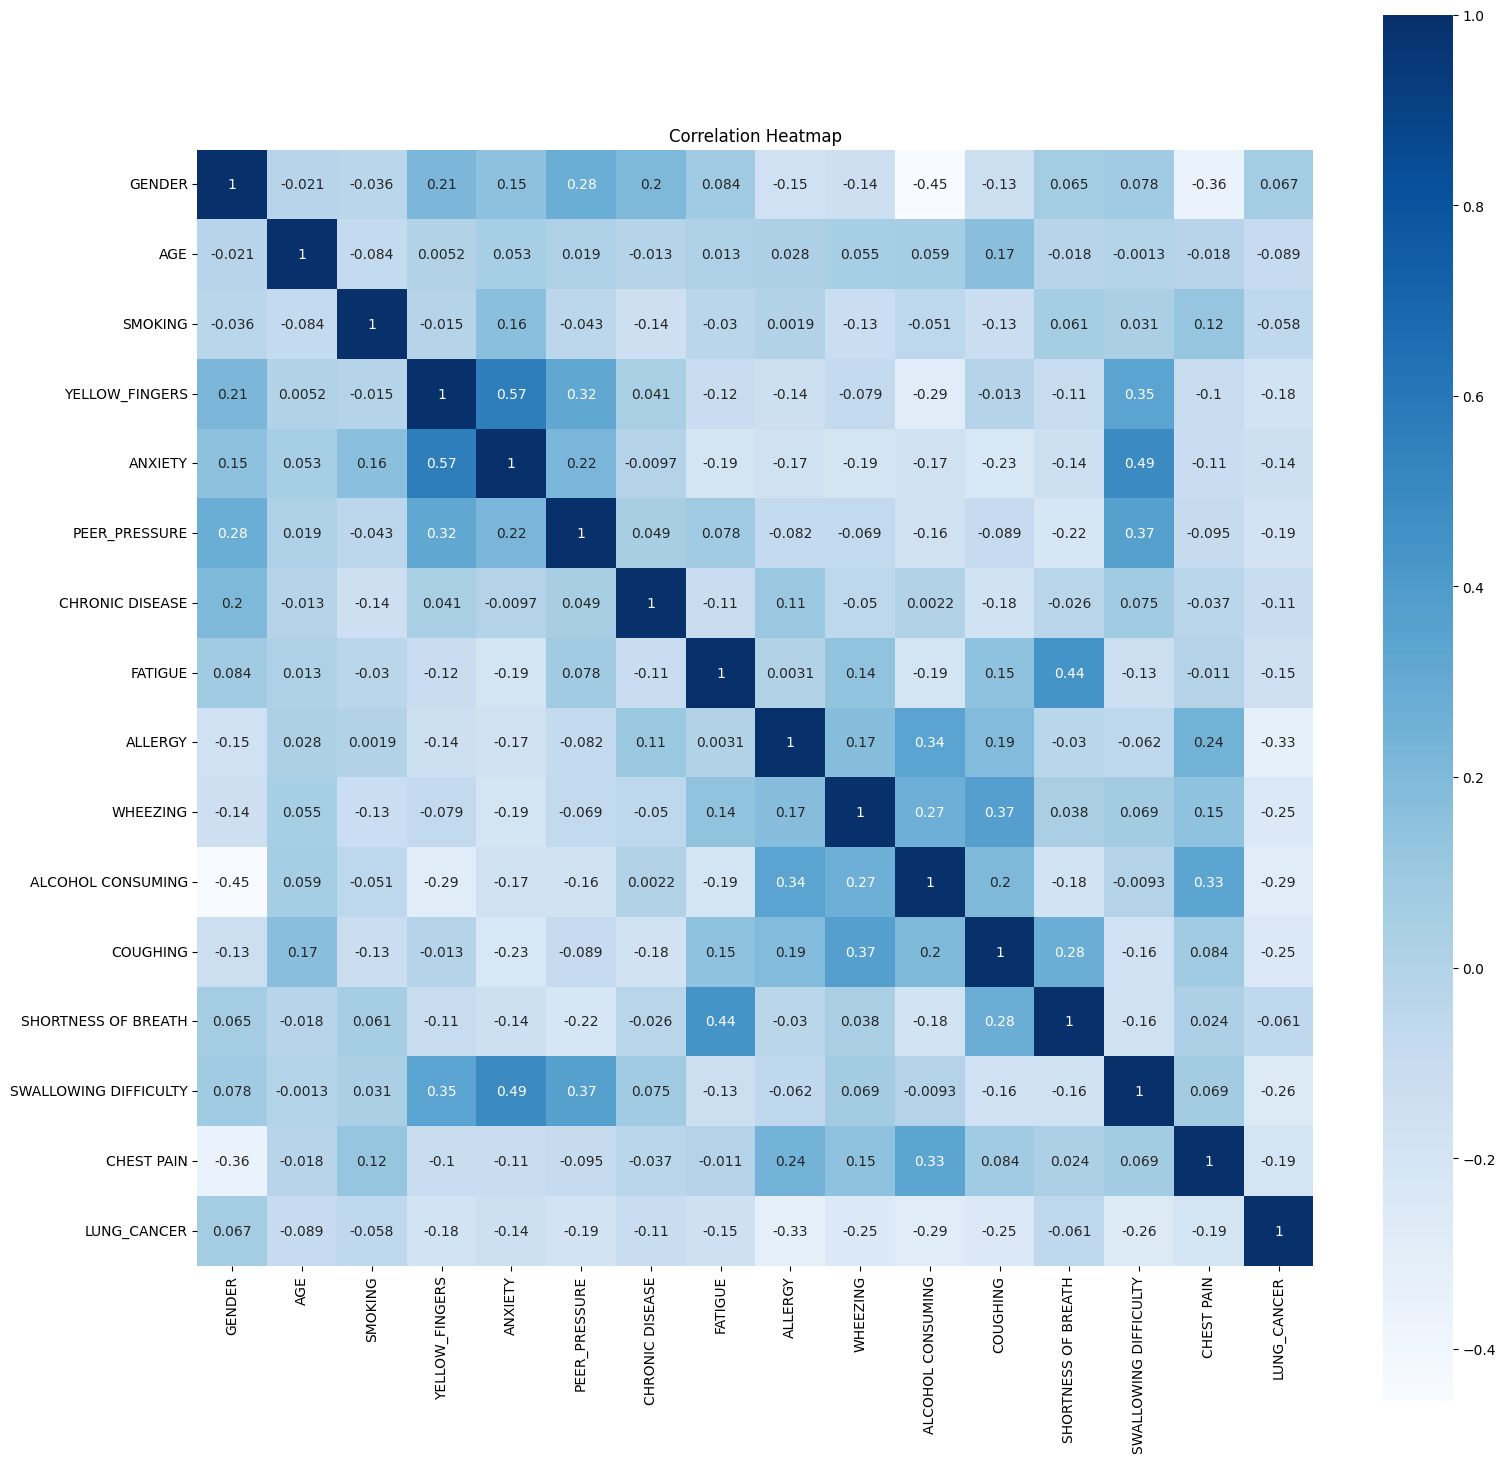

In [ ]:
# Correlation Analysis
print("\n=== Correlation Analysis ===")
cn = lung_data.corr()
plt.figure(figsize=(18,18))
sns.heatmap(cn, cmap="Blues", annot=True, square=True)
plt.title("Correlation Heatmap")
plt.show()

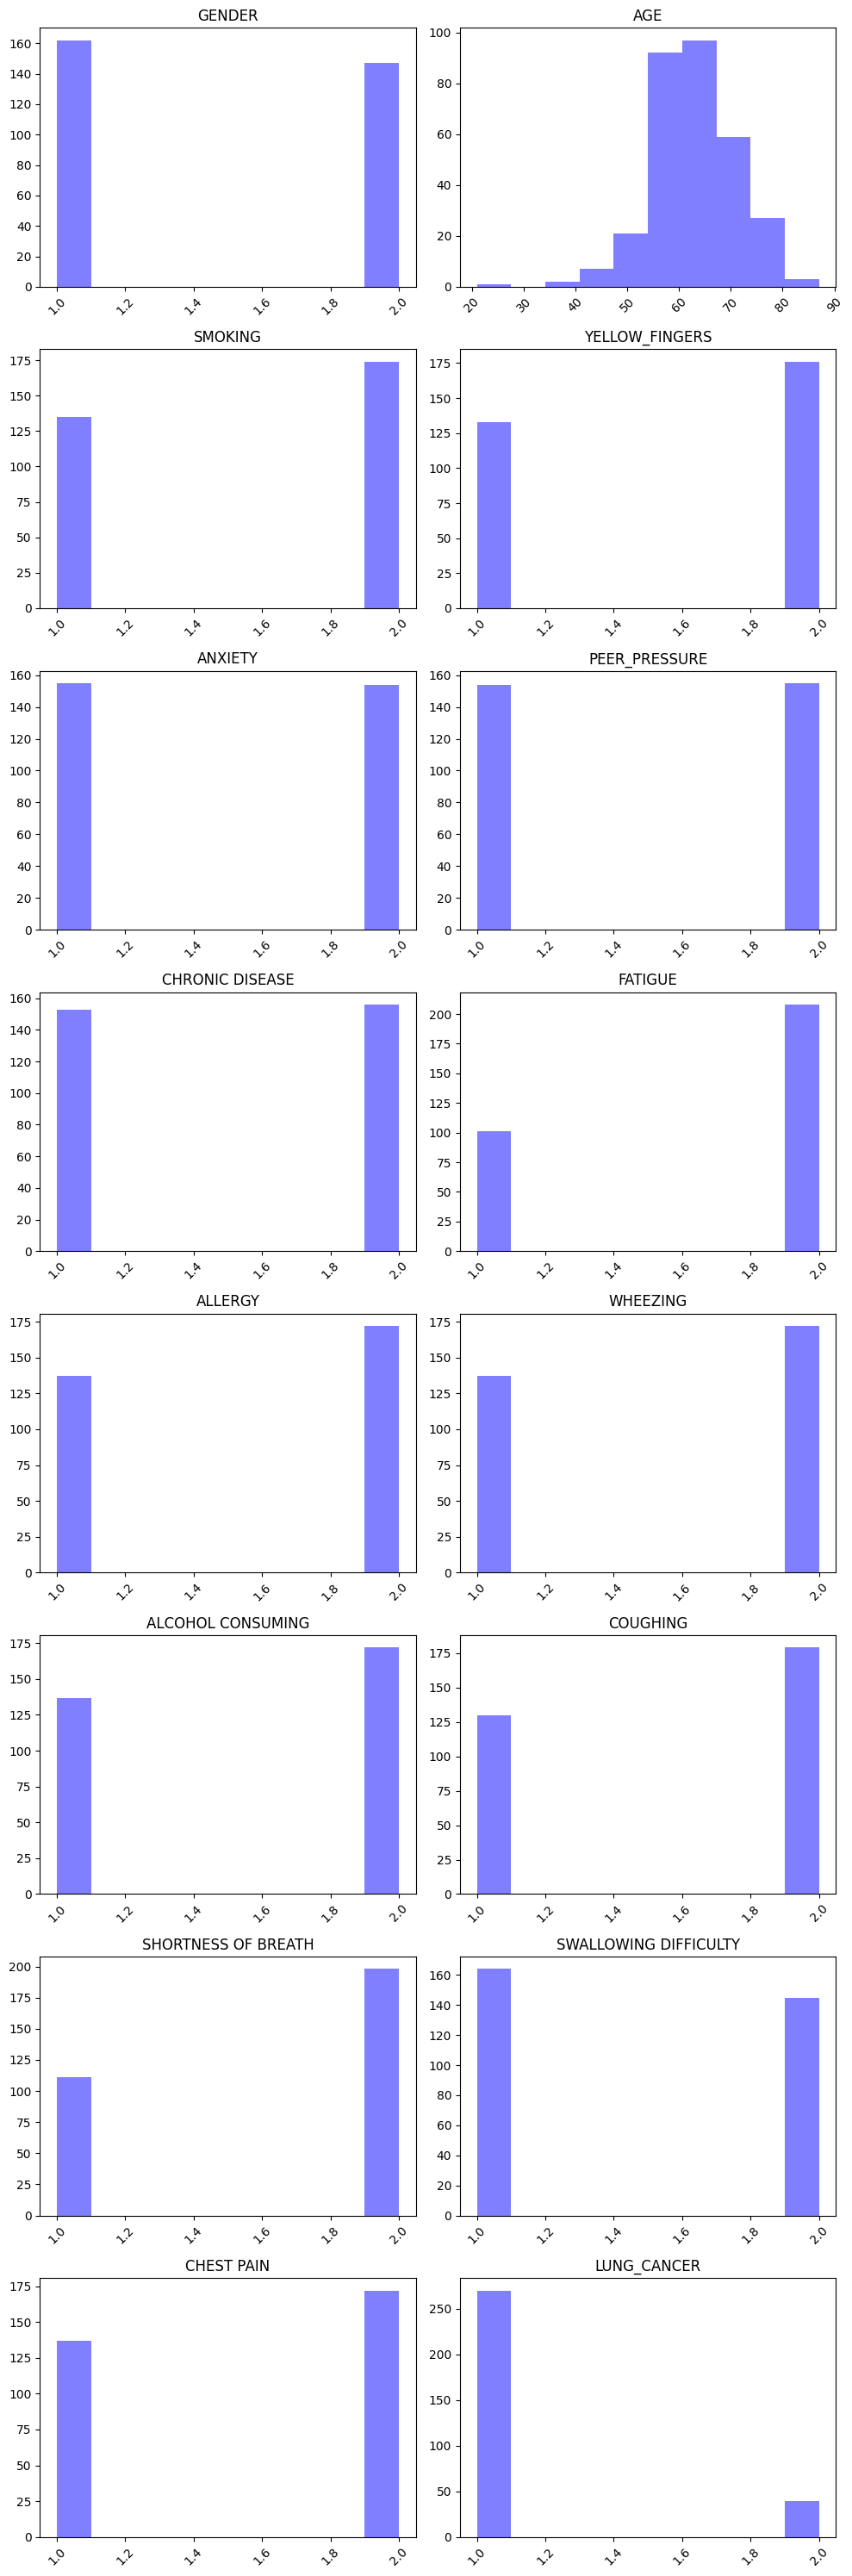

In [ ]:
# Histograms
num_list = list(lung_data.columns)
fig = plt.figure(figsize=(10,30))
for i in range(len(num_list)):
    plt.subplot(8,2,i+1)
    plt.title(num_list[i])
    plt.xticks(rotation=45)
    plt.hist(lung_data[num_list[i]], color='blue', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Final Accuracy Summary
print("\n=== Final Accuracy Summary ===")
for model, acc in accuracies.items():
    print(f"{model}: {acc:.4f}")


=== Final Accuracy Summary ===
Logistic Regression: 0.8835
KNN: 0.8835
Decision Tree: 0.9029
SVM: 0.8544
Naive Bayes: 0.8641
Random Forest: 0.9126
Maya Hybrid: 0.8835


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define base estimators
base_estimators = [
    ('svc', SVC(probability=True)),
    ('dt', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier())
]

# Define Maya Hybrid Model (Stacking Classifier)
maya_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3
)

# Define hyperparameter grid for Random Search
param_dist = {
    'svc__C': np.logspace(-2, 2, 5),
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto'],
    'dt__max_depth': [5, 10, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 5],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'final_estimator__C': np.logspace(-2, 2, 5)
}

# Perform Random Search
random_search = RandomizedSearchCV(maya_model, param_dist, n_iter=30, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(x_train_bal, y_train_bal)

# Best model and evaluation
best_maya_model = random_search.best_estimator_
y_pred = best_maya_model.predict(x_test)

# Print results
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'svc__kernel': 'linear', 'svc__gamma': 'auto', 'svc__C': np.float64(10.0), 'knn__weights': 'uniform', 'knn__n_neighbors': 7, 'final_estimator__C': np.float64(1.0), 'dt__min_samples_split': 2, 'dt__min_samples_leaf': 5, 'dt__max_depth': 10}
Accuracy: 0.9029126213592233
Confusion Matrix:
 [[82  8]
 [ 2 11]]
